See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [3]:
pip install QuantumRingsLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.8 MB/s eta 0:00:00


In [4]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math


provider = QuantumRingsProvider(
    token='rings-200.tJPW6hubhBeKcISboiTcn9C0fpfSVlV7',
    name='linussr2@illinois.edu'
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': 'linussr2@illinois.edu',
 'token': 'rings-200.tJPW6hubhBeKcISboiTcn9C0fpfSVlV7',
 'max_qubits': '200'}

Step 2. Define the core methods

In [5]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Step 3. Perform the algorithm

In [47]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
numberofqubits = 14
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers
#qc.h(0)
#qc.h(1)
#qc.h(2)
#qc.x(6)
#qc.barrier()

# Modular exponentiation 7^x mod 15

def fcarry(i,j,k,l):
  qc.ccx(q[j],q[k],q[l])
  qc.cx(q[j],q[k])
  qc.ccx(q[i],q[k],q[l])

def bcarry(i,j,k,l):
  qc.ccx(q[i],q[k],q[l])
  qc.cx(q[j],q[k])
  qc.ccx(q[j],q[k],q[l])

def fsum(i,j,k):
  qc.cx(q[j],q[k])
  qc.cx(q[i],q[k])

def bsum(i,j,k):
  qc.cx(q[i],q[k])
  qc.cx(q[j],q[k])

def f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2):
  fcarry(c0,a0,b0,c1)
  fcarry(c1,a1,b1,c2)
  fcarry(c2,a2,b2,b3)
  qc.cx(q[a2],q[b2])
  fsum(c2,a2,b2)
  bcarry(c1,a1,b1,c2)
  fsum(c1,a1,b1)
  bcarry(c0,a0,b0,c1)
  fsum(c0,a0,b0)

def b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2):
  bsum(c0,a0,b0)
  fcarry(c0,a0,b0,c1)
  bsum(c1,a1,b1)
  fcarry(c1,a1,b1,c2)
  bsum(c2,a2,b2)
  qc.cx(q[a2],q[b2])
  bcarry(c2,a2,b2,b3)
  bcarry(c1,a1,b1,c2)
  bcarry(c0,a0,b0,c1)

def f_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0):
  f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.swap(q[a0],q[n0])
  qc.swap(q[a1],q[n1])
  qc.swap(q[a2],q[n2])
  b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

  qc.x(q[b3])
  qc.cx(q[b3],q[t0])
  qc.x(q[b3])

  qc.cx(q[a2],q[t0])
  qc.cx(q[a0],q[t0])
  f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cx(q[a0],q[t0])
  qc.cx(q[a2],q[t0])

  qc.swap(q[a0],q[n0])
  qc.swap(q[a1],q[n1])
  qc.swap(q[a2],q[n2])

  b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cx(q[b3],q[t0])
  f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

def b_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0):
  b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cx(q[b3],q[t0])
  f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

  qc.swap(q[a0],q[n0])
  qc.swap(q[a1],q[n1])
  qc.swap(q[a2],q[n2])

  qc.cx(q[a2],q[t0])
  qc.cx(q[a0],q[t0])
  b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cx(q[a0],q[t0])
  qc.cx(q[a2],q[t0])

  qc.x(q[b3])
  qc.cx(q[b3],q[t0])
  qc.x(q[b3])

  f_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.swap(q[a0],q[n0])
  qc.swap(q[a1],q[n1])
  qc.swap(q[a2],q[n2])
  b_adder(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

def f_mult_mod(c0,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2):
  qc.cxx(q[c0],q[z0],q[a0])
  qc.cxx(q[c0],q[z0],q[a1])
  f_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z0],q[a1])
  qc.cxx(q[c0],q[z0],q[a0])

  qc.cxx(q[c0],q[z1],q[a0])
  f_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z1],q[a0])

  qc.cxx(q[c0],q[z2],q[a0])
  f_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z2],q[a0])

  qc.x(q[c0])
  qc.cxx(q[c0],q[z0],q[b0])
  qc.cxx(q[c0],q[z1],q[b1])
  qc.cxx(q[c0],q[z2],q[b2])
  qc.x(q[c0])

def b_mult_mod(c0,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2):
  qc.x(q[c0])
  qc.cxx(q[c0],q[z0],q[b0])
  qc.cxx(q[c0],q[z1],q[b1])
  qc.cxx(q[c0],q[z2],q[b2])
  qc.x(q[c0])

  qc.cxx(q[c0],q[z2],q[a0])
  b_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z2],q[a0])

  qc.cxx(q[c0],q[z1],q[a0])
  b_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z1],q[a0])

  qc.cxx(q[c0],q[z0],q[a0])
  qc.cxx(q[c0],q[z0],q[a1])
  b_adder_mod(a0,a1,a2,b0,b1,b2,b3,c0,c1,c2,n0,n1,n2,t0)
  qc.cxx(q[c0],q[z0],q[a1])
  qc.cxx(q[c0],q[z0],q[a0])

def mod_exp(x0,x1,x2,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2):

  f_mult_mod(x0,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cswap(q[x0],q[z0],q[b0])
  qc.cswap(q[x0],q[z1],q[b1])
  qc.cswap(q[x0],q[z1],q[b1])
  b_mult_mod(x0,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

  f_mult_mod(x1,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cswap(q[x1],q[z0],q[b0])
  qc.cswap(q[x1],q[z1],q[b1])
  qc.cswap(q[x1],q[z1],q[b1])
  b_mult_mod(x1,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)

  f_mult_mod(x2,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)
  qc.cswap(q[x2],q[z0],q[b0])
  qc.cswap(q[x2],q[z1],q[b1])
  qc.cswap(q[x2],q[z1],q[b1])
  b_mult_mod(x2,z0,z1,z2,a0,a1,a2,b0,b1,b2,b3,c0,c1,c2)









#qc.cx(q[2],q[4] )
#qc.cx(q[2],q[5] )
#qc.cx(q[6],q[4] )
#qc.ccx(q[1],q[5],q[3] )
#qc.cx(q[3],q[5] )
#qc.ccx(q[1],q[4],q[6] )
#qc.cx(q[6],q[4] ) #




qc.barrier()

# IQFT. Refer to implementation from earlier examples
#iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

IndentationError: expected an indented block after function definition on line 131 (<ipython-input-47-0e1307b405fa>, line 144)

The circuit to factor 15 shown above.

Job Running
Job Done.
Ending Job Monitor


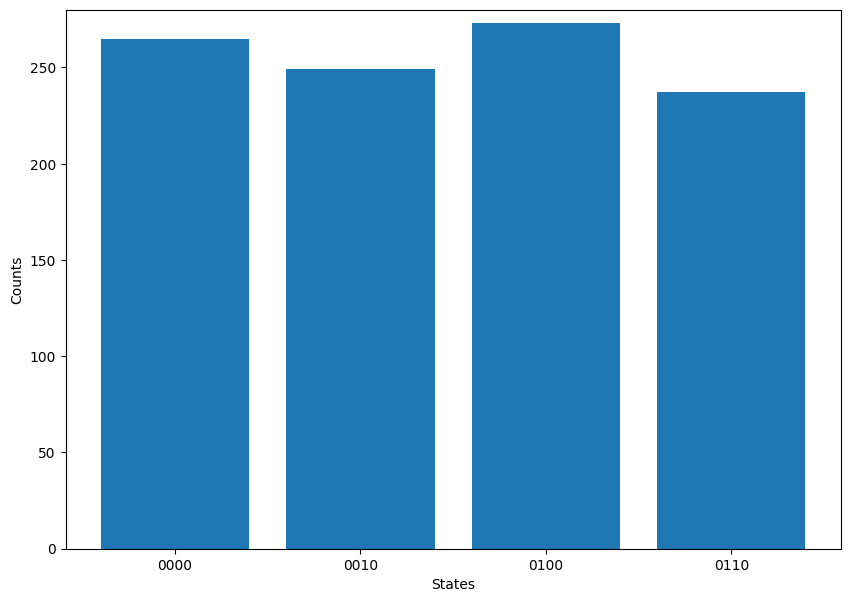

In [26]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)
r = len(counts)

#clean up
del q, c, qc
del result
del job

In [37]:
#calculate factors from Euclidian algo


def gcd(a, b):
    if a == 0:
        return b
    return gcd(b % a, a)

fac1 = gcd(7**(r/2)-1,15)
fac2 = gcd(7**(r/2)+1,15)
print(str(fac1)+' , '+str(fac2))

3.0 , 5.0


A plot of the execution results is shown above. Compare this with the calculated values.

Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers